# BERT

In [1]:
import torch
import os
import sys
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(r'D:\code\Python-Project\文本数据挖掘\WBClassify')))
from WBClassify.Utils import utils,vocab,Trie
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import random 
import warnings
warnings.filterwarnings('ignore')
def seed_torch(seed=42):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

seed_torch()

In [2]:
from transformers import BertTokenizer
from transformers import BertForTokenClassification
# 加载字典和分词工具
token = BertTokenizer.from_pretrained("bert-base-chinese")
token

PreTrainedTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [3]:
def load_data(batch_size,num_steps=25,path="../Get_Data/train2.csv",collate_fn=None):
    """加载数据

    Args:
        batch_size (int): 小批量
        num_steps (int, optional): 时间步数，截断填充指定. Defaults to 20.
        path (str, optional): 文件路径. Defaults to "../Get_Data/train.csv".

    Returns:
        _type_: _description_
    """
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split

    data = pd.read_csv(path)
    data['title'] = data['title'].map(utils.got_chinese)        # 取出中文
    data['title'] = data['title'].map(lambda x: x.replace("|","")) 
    X = data['title'].values
    y = data['label']
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2 ,shuffle=True ,random_state=1,stratify=y)
    train_dataset = utils.Dataset(list(zip(x_train,y_train)))
    test_dataset = utils.Dataset(list(zip(x_test,y_test)))
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
    return train_data_loader,test_data_loader,encoder

In [4]:
def collate_fn(data):
    inputs = [i[0] for i in data]
    labels = [i[1] for i in data]

    # 编码
    data = token.batch_encode_plus(
        batch_text_or_text_pairs = inputs,
        truncation = True,
        padding="max_length",
        return_tensors = "pt",
        return_length = True,
    )

    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    token_type_ids = data['token_type_ids']
    labels = torch.LongTensor(labels)       # nlp中常用LongTensor，64位浮点型
    return input_ids, attention_mask, token_type_ids, labels


In [5]:
train_data_loader,test_data_loader,encoder = load_data(64,collate_fn=collate_fn)

In [6]:
for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(train_data_loader):
    break
print(len(train_data_loader))
input_ids.shape, attention_mask.shape, token_type_ids.shape, labels

63


(torch.Size([64, 512]),
 torch.Size([64, 512]),
 torch.Size([64, 512]),
 tensor([1, 3, 2, 1, 4, 0, 1, 2, 0, 1, 0, 0, 4, 1, 1, 0, 0, 4, 2, 4, 2, 4, 1, 3,
         3, 1, 2, 1, 2, 3, 2, 1, 1, 3, 3, 3, 3, 4, 1, 3, 3, 1, 2, 2, 4, 2, 1, 2,
         2, 1, 1, 0, 4, 2, 0, 2, 0, 4, 0, 1, 3, 3, 1, 4]))

In [7]:
from transformers import BertModel

# 加载预训练模型
pretrained = BertModel.from_pretrained("bert-base-chinese")

# 不训练，不需要梯度
# 预训练模型的参数我们不进行调整，只计算下游任务的参数
for param in pretrained.parameters():
    param.requires_grad_(False)
pretrained.to("cuda:0")
# 模型计算
out = pretrained(
    input_ids = input_ids.to("cuda:0"),
    attention_mask=attention_mask.to("cuda:0"),
    token_type_ids=token_type_ids.to("cuda:0")
)
out.last_hidden_state.shape,out.last_hidden_state

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(torch.Size([64, 512, 768]),
 tensor([[[ 0.2841,  0.1290, -1.0301,  ...,  0.4248, -0.6587, -0.3318],
          [-0.5139,  0.4741,  0.0357,  ..., -0.8241, -0.9715, -0.3577],
          [ 0.0675,  0.1251,  0.5133,  ...,  0.1465, -0.3534, -0.5758],
          ...,
          [-0.4131, -0.0133, -0.8732,  ...,  0.2989, -0.3889, -0.1700],
          [-0.3561,  0.0488, -1.0103,  ...,  0.3690, -0.3502, -0.1898],
          [-0.4564,  0.0292, -0.7888,  ...,  0.4825, -0.0936, -0.1579]],
 
         [[-0.1716,  0.4567, -1.5820,  ...,  0.0341,  0.3879,  0.4233],
          [-0.3335,  0.5032,  0.0066,  ...,  0.3245, -0.2591,  0.4805],
          [-0.0705, -1.0937, -0.7814,  ...,  0.8948,  0.2576,  0.1494],
          ...,
          [-0.5359,  0.1182, -0.7300,  ...,  0.2496,  0.0291, -0.0367],
          [-0.5821,  0.1201, -0.7844,  ...,  0.2770,  0.0378, -0.1022],
          [-0.6910, -0.0703, -0.6694,  ...,  0.5858,  0.2387, -0.0127]],
 
         [[ 0.6709,  0.6071, -1.3259,  ...,  0.2220, -0.4791, -0.0793],

In [8]:
# 定义下游任务模型

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(768,len(encoder.classes_))
    
    def forward(self,input_ids,attention_mask,token_type_ids):
        # 特征抽取
        with torch.no_grad():
            out = pretrained(
                input_ids = input_ids,
                attention_mask = attention_mask,
                token_type_ids = token_type_ids
            )
        out = self.fc(out.last_hidden_state[:,0])   # 只需要取第0个词进行分类就可以了，这与bert的设计有关
        return out

model = Model()
pretrained.to("cuda:0");

In [9]:
def train_batch_with_bert(net, X , y, loss, optimizer, device):
    if isinstance(X, list):
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)
    y = y.to(device)
    net.train()
    optimizer.zero_grad()
    pred = net(*X)              # 解包传参
    l = loss(pred, y)
    l.sum().backward()
    optimizer.step()
    train_loss_sum = l.sum()
    train_acc_sum = utils.acc(pred,y)
    return train_loss_sum, train_acc_sum

In [10]:
def evaluate_acc(net, data_iter, device=None):
    """评估测试集

    Args:
        net (_type_): _description_
        data_iter (_type_): _description_
        device (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    if isinstance(net, torch.nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device

    metric = utils.Accumulator(2)

    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in data_iter:
            X = [input_ids, attention_mask, token_type_ids]
            y = labels
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(utils.acc(net(*X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
def train_with_bert(net, train_iter, test_iter, loss, optimizer, num_epochs,
               device,scheduler=None):
    """传入句子长度的训练
    acc始终是累加的，每个epoch结束，输出当前正确率

    Args:
        net (_type_): _description_
        train_iter (_type_): _description_
        test_iter (_type_): _description_
        loss (_type_): _description_
        optimizer (_type_): _description_
        num_epochs (_type_): _description_
        device (_type_, optional): _description_. Defaults to device.
    """
    train_acc_list = []
    test_acc_list = []
    train_loss_list = []
    num_batches = len(train_iter)

    net.to(device)
    for epoch in range(num_epochs):
        print("-"*65)
        metric = utils.Accumulator(4)
        for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_iter):
            l, acc = train_batch_with_bert(
                net, [input_ids, attention_mask, token_type_ids], labels, loss, optimizer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                
                print(f"| epoch{epoch:3d} | avg_loss:{metric[0] / metric[2]:.3f} | train_acc:{metric[1] / metric[3]:.2f} |")
                
        if scheduler:
            scheduler.step()                                # 进行warm up
        print('-'*65)      
        test_acc = evaluate_acc(net, test_iter)
        print(f"| epoch{epoch:3d} | avg_loss:{metric[0] / metric[2]:.3f} | train_acc:{metric[1] / metric[3]:.2f} | test_acc:{test_acc:.2f}| lr:{optimizer.param_groups[0]['lr']} | ")
        train_acc_list.append(metric[1] / metric[3])
        train_loss_list.append(metric[0] / metric[2])
        test_acc_list.append(test_acc)
        
    print("-"*89)   
    print("final metris:")
    print(f'| avg_loss {metric[0] / metric[2]:.3f} | train acc '
          f'{metric[1] / metric[3]:.3f} | test acc {test_acc:.3f} |')
    train_acc_list.append(metric[1] / metric[3])
    train_loss_list.append(metric[0] / metric[2])
    test_acc_list.append(test_acc)
    plt.plot(train_acc_list,label="train_acc")
    plt.plot(train_loss_list,label="train_loss")
    plt.plot(test_acc_list,label="test_acc")
    plt.legend()
    plt.show()

-----------------------------------------------------------------
| epoch  0 | avg_loss:1.159 | train_acc:0.56 |
| epoch  0 | avg_loss:0.848 | train_acc:0.69 |
| epoch  0 | avg_loss:0.717 | train_acc:0.74 |
| epoch  0 | avg_loss:0.647 | train_acc:0.77 |
| epoch  0 | avg_loss:0.599 | train_acc:0.79 |
| epoch  0 | avg_loss:0.592 | train_acc:0.79 |
-----------------------------------------------------------------
| epoch  0 | avg_loss:0.592 | train_acc:0.79 | test_acc:0.87| lr:0.01 | 
-----------------------------------------------------------------
| epoch  1 | avg_loss:0.351 | train_acc:0.89 |
| epoch  1 | avg_loss:0.316 | train_acc:0.90 |
| epoch  1 | avg_loss:0.313 | train_acc:0.89 |
| epoch  1 | avg_loss:0.313 | train_acc:0.90 |
| epoch  1 | avg_loss:0.330 | train_acc:0.89 |
| epoch  1 | avg_loss:0.333 | train_acc:0.89 |
-----------------------------------------------------------------
| epoch  1 | avg_loss:0.333 | train_acc:0.89 | test_acc:0.86| lr:0.01 | 
--------------------------

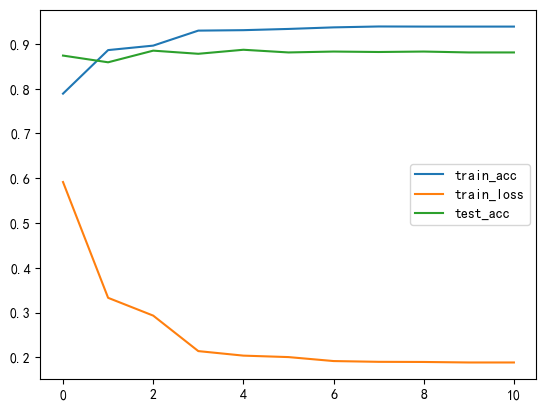

In [12]:
from transformers import AdamW

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 训练
optimizer = AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)       # warm up
criterion = torch.nn.CrossEntropyLoss(reduction='none')                     # 不进行取均值
num_epochs = 10
train_with_bert(model,train_data_loader,test_data_loader,criterion,optimizer,num_epochs,device=device,scheduler=scheduler)